## Runnning with gammapy-dev/IRF_model
Fitting asimov datasets with nuisance parameters based on the different livetimes

### Setup

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from gammapy.maps import Map
from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit,  Parameters, Covariance , Parameter
from gammapy.datasets import MapDataset ,Datasets, FluxPointsDataset
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    SkyModel,
    PointSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
    PiecewiseNormSpectralModel,
)
from gammapy.estimators import TSMapEstimator, ExcessMapEstimator
from gammapy.estimators import FluxPoints, FluxPointsEstimator
from scipy.interpolate import interp2d

from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys
sys.path.append('../')
import Dataset_load 

from  Dataset_Setup import Setup, GaussianCovariance_matrix

from matplotlib import rc
rc("font", **{"family": "serif", "serif": ["Computer Modern"]})
rc("text", usetex=True)


## Read dataset

In [2]:
c = Dataset_load.load_config()
awo, aw, ewo, ew = c['_colors']  


In [3]:
livetime = 100.0 # c['livetime']
zero = c['zero'] 
norm = c['norm'] 
tilt = c['tilt'] 
bias = c['bias'] 
resolution = c['resolution'] 
magnitude = c['magnitude'] 
corrlength = c['corrlength']
sys = c['sys'] 
folder = c['folder']
parameter_names = c['parameter_names']        
nbidx = 0
print(livetime)
print(sys)

100.0
Bkgext


In [4]:
c['model']

'crab_cutoff'

In [5]:
%%time
amplitude= Parameter('amplitude', value = 3.85e-12, unit=u.Unit("1 / (TeV s cm2)"))
dataset_input_point  = Dataset_load.create_asimov(model = c['model'], source = c['source'], 
                                               livetime = f"{livetime}-hr",
                                        parameters = [amplitude],
                                           spatial_model =None)
from gammapy.modeling.models import GaussianSpatialModel
gaussian = GaussianSpatialModel(lon_0 = dataset_input_point.models.parameters['lon_0'],
                                lat_0 = dataset_input_point.models.parameters['lat_0'],
                                sigma = 0.3 *u.deg
                               )


dataset_input  = Dataset_load.create_asimov(model = c['model'], source = c['source'], 
                                               livetime = f"{livetime}-hr",
                                        parameters = [amplitude],
                                           spatial_model =gaussian)


loaded dataset:
/home/katrin/Documents/nuisance_summary/PKS_flare/HESS_public/dataset-simulated-100.0-hr.fits.gz
loaded dataset:
/home/katrin/Documents/nuisance_summary/PKS_flare/HESS_public/dataset-simulated-100.0-hr.fits.gz
CPU times: user 10.4 s, sys: 604 ms, total: 11 s
Wall time: 11 s


<WCSAxes: >

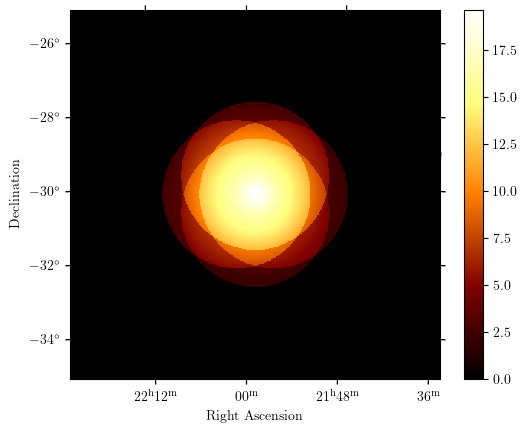

In [6]:
dataset_input.npred().sum_over_axes().plot(add_cbar =1)

setup bkg V
add_bkg_systematic_V
magnitude 10 corrlength 2


array([1.        , 0.        , 0.        , 0.        , 0.        ,
       0.1       , 0.06666667, 0.03333333, 0.        , 0.00625   ,
       0.0125    , 0.01875   , 0.025     , 0.03125   , 0.0375    ,
       0.04375   , 0.05      , 0.05625   , 0.0625    , 0.06875   ,
       0.075     , 0.08125   , 0.0875    , 0.09375   , 0.1       ])

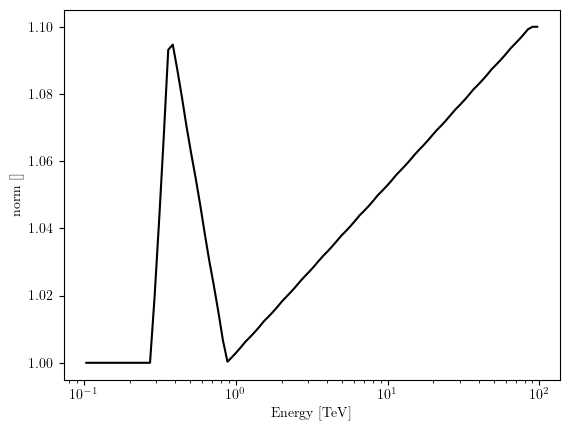

In [7]:
    
setup = Setup(dataset_input=dataset_input)
#setup.set_up_irf_sys(bias, resolution, norm, tilt)
dataset_asimov, dataset_asimov_N = setup.run()
# irf model
#setup.set_irf_model(dataset_asimov_N)
if "Bkg" in sys or "BKG" in sys:

    # piece wise model
    # remove old bkg model
    setup.set_up_bkg_sys_V( breake = 3,
                        index1 = 8,
                        index2 = 1.5, 
                        magnitude = magnitude )

    dataset_asimov, dataset_asimov_N = setup.run()

    #setup.unset_model(dataset_asimov_N, FoVBackgroundModel)
    #setup.set_piecewise_bkg_model(dataset_asimov_N)
    # energy of the following parameters smaller than ethrshold
    dataset_asimov_N.background_model.parameters['norm0'].frozen = True
    dataset_asimov_N.background_model.parameters['norm1'].frozen = True
    dataset_asimov_N.background_model.parameters['norm2'].frozen = True
    dataset_asimov_N.background_model.parameters['norm3'].frozen = True
    print("magnitude", magnitude, "corrlength", corrlength)
    setup.set_bkg_prior(dataset_asimov_N, magnitude= magnitude, corrlength= corrlength)
    frozen_pos = 1
    if frozen_pos:
        dataset_asimov.models.parameters['lon_0'].frozen = True
        dataset_asimov.models.parameters['lat_0'].frozen = True
        dataset_asimov_N.models.parameters['lon_0'].frozen = True
        dataset_asimov_N.models.parameters['lat_0'].frozen = True
    else:
        for d in [dataset_asimov, dataset_asimov_N]:
            delta = 0.01 
            dataset_asimov.models.parameters['lon_0'].min = dataset_asimov.models.parameters['lon_0'].value - delta
            dataset_asimov.models.parameters['lon_0'].max = dataset_asimov.models.parameters['lon_0'].value + delta 
            dataset_asimov.models.parameters['lat_0'].min = dataset_asimov.models.parameters['lat_0'].value - delta
            dataset_asimov.models.parameters['lat_0'].max = dataset_asimov.models.parameters['lat_0'].value + delta
                
         
    
    
ax = setup.dataset_helper.background_model.spectral_model.plot(color= 'black')

ax.set_yscale("linear")
setup.dataset_helper.background_model.spectral_model.parameters.value

In [8]:
dataset_asimov_N.background_model.evaluate(1*u.TeV)

<Quantity [1.]>

In [9]:
setup.dataset_helper.background_model.evaluate(1*u.TeV)

<Quantity [1.00290053]>

<WCSAxes: >

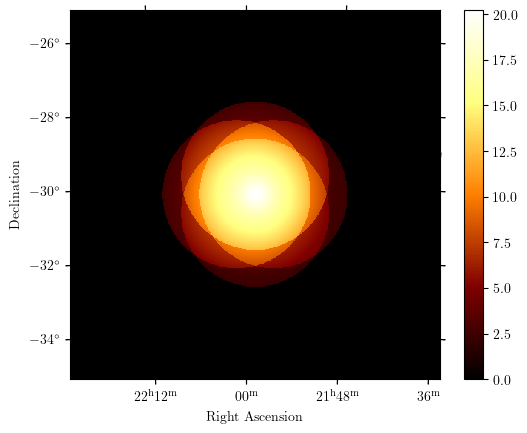

In [10]:
setup.dataset_helper.counts.sum_over_axes().plot(add_cbar = 1)

<WCSAxes: >

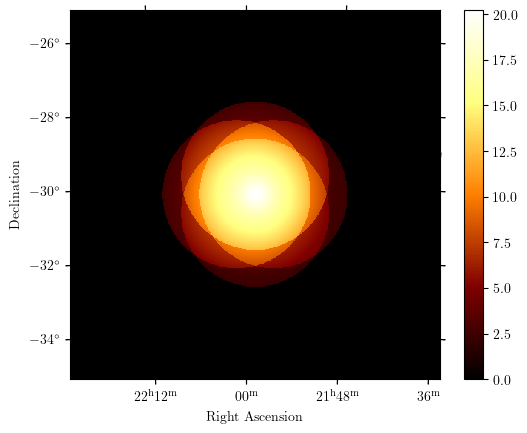

In [11]:
setup.dataset_helper.npred().sum_over_axes().plot(add_cbar = 1)

<WCSAxes: >

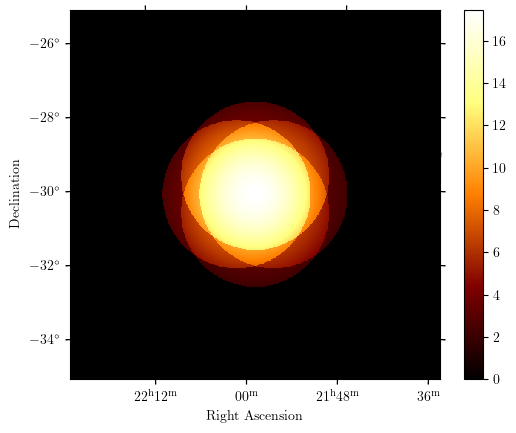

In [12]:
setup.dataset_helper.npred_background().sum_over_axes().plot(add_cbar = 1)

shift 1.0


(<WCSAxes: >,
 <Axes: xlabel='Energy [$\\mathrm{TeV}$]', ylabel='Residuals (data - model)'>)

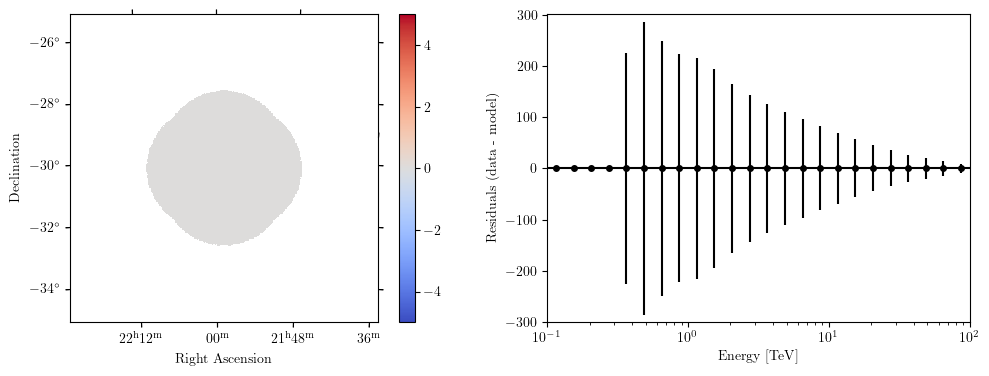

In [13]:
setup.dataset_helper.plot_residuals()

<WCSAxes: >

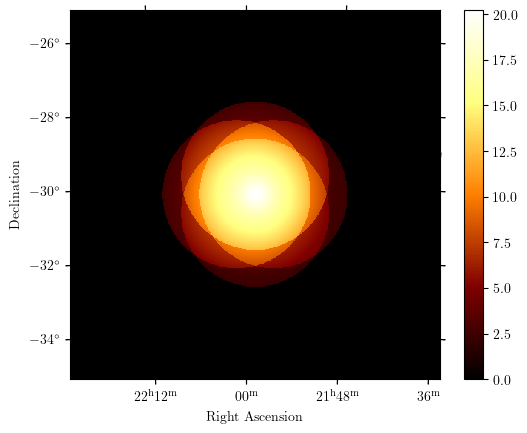

In [14]:
dataset_asimov_N.counts.sum_over_axes().plot(add_cbar = 1)

<WCSAxes: >

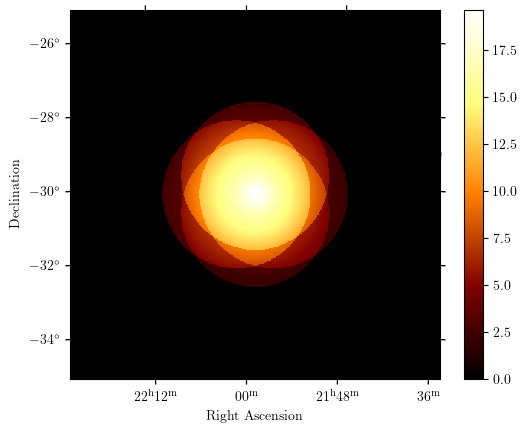

In [15]:
dataset_asimov_N.npred().sum_over_axes().plot(add_cbar = 1)

<WCSAxes: >

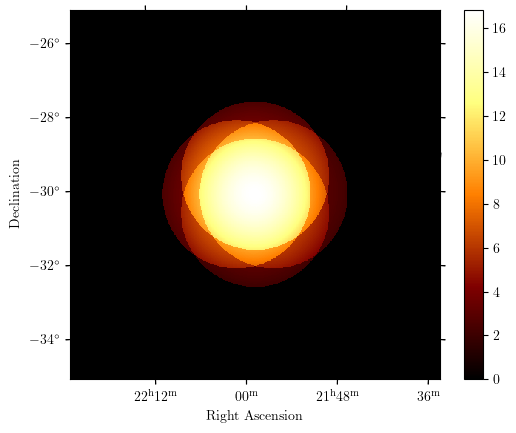

In [16]:
dataset_asimov_N.npred_background().sum_over_axes().plot(add_cbar = 1)

shift 1.0


(<WCSAxes: >,
 <Axes: xlabel='Energy [$\\mathrm{TeV}$]', ylabel='Residuals (data - model)'>)

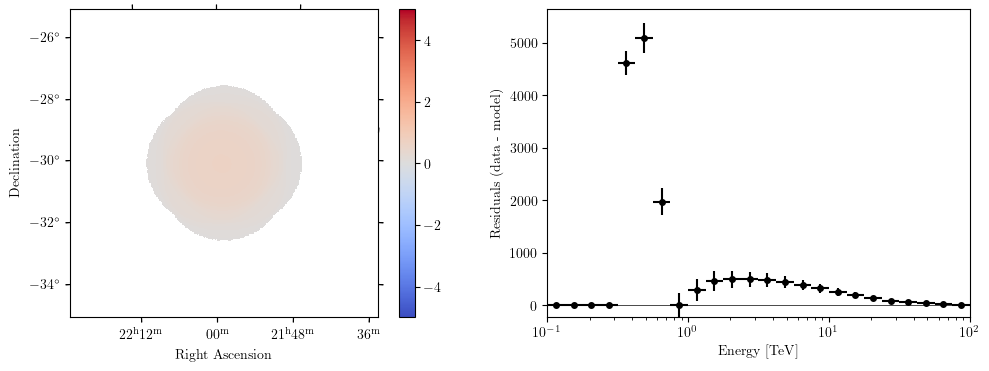

In [17]:
dataset_asimov_N.plot_residuals()


In [18]:
%%time
fitting = 1
if fitting:
    fit_cor = Fit(store_trace=0)
    minuit_opts = {"tol": 0.1, "strategy": 2}
    fit_cor.backend = "minuit"
    fit_cor.optimize_opts = minuit_opts
    result_cor = fit_cor.run(dataset_asimov)
    print(result_cor)
    print("saving")
    path = f'../{folder}/data/0_model_livetime_{livetime}.yml'
    dataset_asimov.models.write(path,overwrite=True)
    
    
else:
    path = f'../{folder}/data/0_model_livetime_{livetime}.yml'
    dataset_asimov.models = Models.read(path)
    print(path[:-4])
    cov = dataset_asimov.models.read_covariance(path = path[:-4]+"_covariance.dat", filename = "",
                                            format="ascii.fixed_width")


OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 278
	total stat : 846434.46

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.

saving
CPU times: user 23.1 s, sys: 3.68 s, total: 26.8 s
Wall time: 26.7 s


In [19]:
%%time
fitting = 0
if fitting:
    fit_cor = Fit(store_trace=0)
    result_cor = fit_cor.run(dataset_asimov_N)
    print(result_cor)
    print("saving")
    path = f'../{folder}/data/0_model_nui_livetime_{livetime}.yml'
    dataset_asimov_N.models.write(path,overwrite=True)
    
    
else:
    path = f'../{folder}/data/0_model_nui_livetime_{livetime}.yml'
    dataset_asimov_N.models = Models.read(path)
    dataset_asimov_N.background_model.parameters['_norm'].value = 1.

CPU times: user 117 ms, sys: 1.98 ms, total: 119 ms
Wall time: 118 ms


In [20]:
print(dataset_asimov_N.background_model)

FoVBackgroundModel

  Name                      : dataset_N-bkg
  Datasets names            : ['dataset_N']
  Spectral model type       : PiecewiseNormSpectralModel
  Parameters:
    _norm      (frozen)        :      1.000                  
    norm0      (frozen)[prior] :      0.000                  
    norm1      (frozen)[prior] :      0.000                  
    norm2      (frozen)[prior] :      0.000                  
    norm3      (frozen)[prior] :      0.000                  
    norm4              [prior] :      0.100  +/-    0.00             
    norm5              [prior] :      0.068  +/-    0.00             
    norm6              [prior] :      0.031  +/-    0.00             
    norm7              [prior] :      0.003  +/-    0.00             
    norm8              [prior] :      0.004  +/-    0.00             
    norm9              [prior] :      0.014  +/-    0.00             
    norm10             [prior] :      0.018  +/-    0.01             
    norm11           

In [21]:
from scipy.linalg import inv
cov = inv(dataset_asimov_N.background_model.parameters.prior[1].covariance_matrix)
cov[-1]

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.17952853e-12, 1.21143807e-12, 1.31187465e-12, 1.69183287e-12,
       2.56653661e-12, 5.87756580e-12, 7.12940583e-11, 1.52723485e-09,
       2.69986962e-08, 3.72666132e-07, 4.00652866e-06, 3.35462610e-05,
       2.18749111e-04, 1.11089965e-03, 4.39369336e-03, 1.35335283e-02,
       3.24652467e-02, 6.06530660e-02, 8.82496903e-02, 1.00000000e-01])

(0.4, 100)

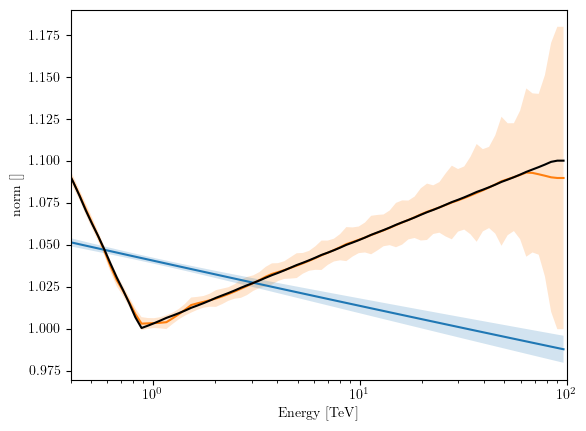

In [22]:
ax = dataset_asimov_N.background_model.spectral_model.plot(color= 'tab:orange')
ax = dataset_asimov_N.background_model.spectral_model.plot_error(facecolor= 'tab:orange')

ax = dataset_asimov.background_model.spectral_model.plot(color= 'tab:blue')
ax = dataset_asimov.background_model.spectral_model.plot_error(facecolor= 'tab:blue')

ax = setup.dataset_helper.background_model.spectral_model.plot(color= 'black')

ax.set_yscale("linear")
ax.set_xlim(0.4, 100)

[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.00000000e-12 1.00000026e-12 1.00002047e-12 1.00126642e-12
 1.06101937e-12 3.28973485e-12 6.79158609e-11 1.52399797e-09
 2.69967850e-08 3.72666317e-07 4.00653074e-06 3.35462638e-05
 2.18749113e-04 1.11089965e-03 4.39369336e-03 1.35335283e-02
 3.24652467e-02 6.06530660e-02 8.82496903e-02 1.00000000e-01]


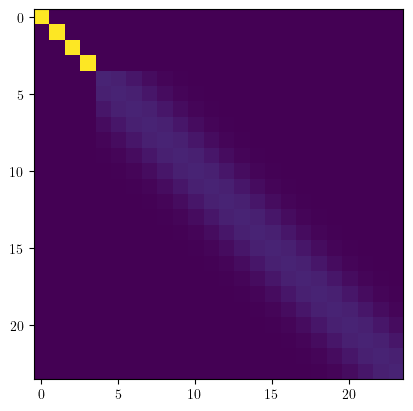

In [23]:
from Dataset_Setup import GaussianCovariance_matrix
cov = GaussianCovariance_matrix(size = len(setup.emask()),
                                        magnitude = magnitude, 
                                        corrlength = corrlength)
plt.imshow(cov.cov())
print(cov.cov()[-1])

shift 1.0
shift 1.0


(-70.0, 70.0)

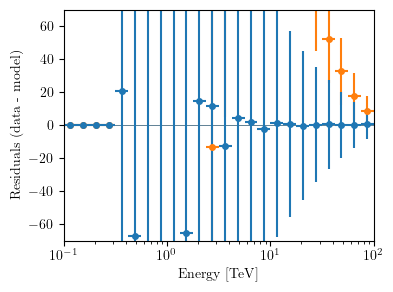

In [24]:
fig, ax = plt.subplots(1,1, figsize = (4,3))
method = 'diff'
ax = dataset_asimov.plot_residuals_spectral(color = 'tab:orange', method = method)
dataset_asimov_N.plot_residuals_spectral(ax = ax, color = 'tab:blue', method = method)
ax.set_ylim(-70,70)

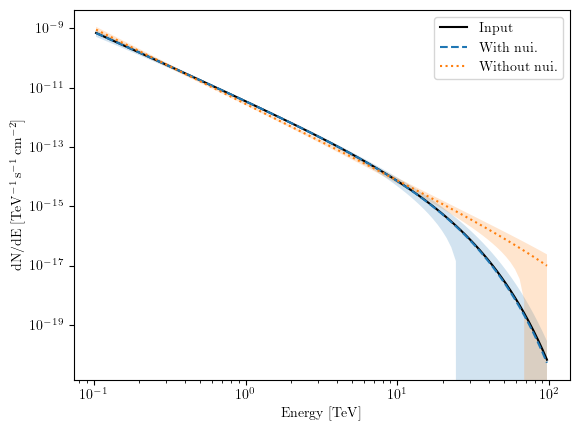

In [25]:

ax = dataset_input.models[0].spectral_model.plot(color = 'black', label = 'Input')
dataset_asimov_N.models[0].spectral_model.plot(color = 'tab:blue', linestyle = 'dashed',
                                                 label = "With nui.")
dataset_asimov_N.models[0].spectral_model.plot_error(ax = ax, facecolor = 'tab:blue')

dataset_asimov.models[0].spectral_model.plot(color = 'tab:orange', linestyle = 'dotted',
                                                 label = "Without nui.")
dataset_asimov.models[0].spectral_model.plot_error(ax = ax, facecolor = 'tab:orange')



ax.legend()

In [26]:
print(setup.dataset_helper.models[0])

SkyModel

  Name                      : Crablog
  Datasets names            : None
  Spectral model type       : ExpCutoffPowerLawSpectralModel
  Spatial  model type       : GaussianSpatialModel
  Temporal model type       : 
  Parameters:
    index                      :      2.300  +/-    0.00             
    amplitude                  :   3.85e-12  +/- 0.0e+00 1 / (TeV s cm2)
    reference  (frozen)        :      1.000      TeV         
    lambda_                    :      0.100  +/-    0.00 1 / TeV     
    alpha      (frozen)        :      1.000                  
    lon_0                      :    329.680  +/-    0.00 deg         
    lat_0                      :    -30.222  +/-    0.00 deg         
    sigma                      :      0.300  +/-    0.00 deg         
    e          (frozen)        :      0.000                  
    phi        (frozen)        :      0.000      deg         




In [27]:
print(dataset_asimov_N.models[0])

SkyModel

  Name                      : Crablog
  Datasets names            : None
  Spectral model type       : ExpCutoffPowerLawSpectralModel
  Spatial  model type       : GaussianSpatialModel
  Temporal model type       : 
  Parameters:
    index                      :      2.295  +/-    0.12             
    amplitude                  :   3.87e-12  +/- 4.4e-13 1 / (TeV s cm2)
    reference  (frozen)        :      1.000      TeV         
    lambda_                    :      0.103  +/-    0.05 1 / TeV     
    alpha      (frozen)        :      1.000                  
    lon_0      (frozen)        :    329.680      deg         
    lat_0      (frozen)        :    -30.222      deg         
    sigma                      :      0.300  +/-    0.02 deg         
    e          (frozen)        :      0.000                  
    phi        (frozen)        :      0.000      deg         




In [28]:
print(dataset_asimov.models[0])

SkyModel

  Name                      : Crablog
  Datasets names            : None
  Spectral model type       : ExpCutoffPowerLawSpectralModel
  Spatial  model type       : GaussianSpatialModel
  Temporal model type       : 
  Parameters:
    index                      :      2.541  +/-    0.10             
    amplitude                  :   2.86e-12  +/- 2.7e-13 1 / (TeV s cm2)
    reference  (frozen)        :      1.000      TeV         
    lambda_                    :      0.010  +/-    0.02 1 / TeV     
    alpha      (frozen)        :      1.000                  
    lon_0      (frozen)        :    329.680      deg         
    lat_0      (frozen)        :    -30.222      deg         
    sigma                      :      0.275  +/-    0.02 deg         
    e          (frozen)        :      0.000                  
    phi        (frozen)        :      0.000      deg         




[1.         0.         0.         0.         0.         0.09956598
 0.0675559  0.03131182 0.00288191 0.00361077 0.01424879 0.01817389
 0.02440123 0.03207598 0.03714039 0.04352923 0.05045236 0.05608751
 0.06235027 0.06904301 0.07477904 0.08067125 0.08789611 0.09328352
 0.08967658]


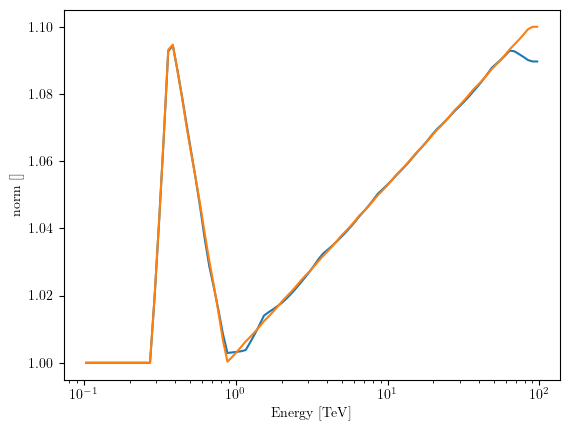

In [29]:


ax = dataset_asimov_N.background_model.spectral_model.plot()
setup.dataset_helper.background_model.spectral_model.plot()
ax.set_yscale("linear")
print(dataset_asimov_N.background_model.spectral_model.parameters.value)

In [30]:
setup.dataset_helper.background_model

In [31]:
import colors as l
aw = l.purple
awo =l.orange

labelw = "Fit with background systematic"
labelwo = "Fit without background systematic"

<Axes: xlabel='Reconstructed Energy [TeV]', ylabel='Background Normalisation'>

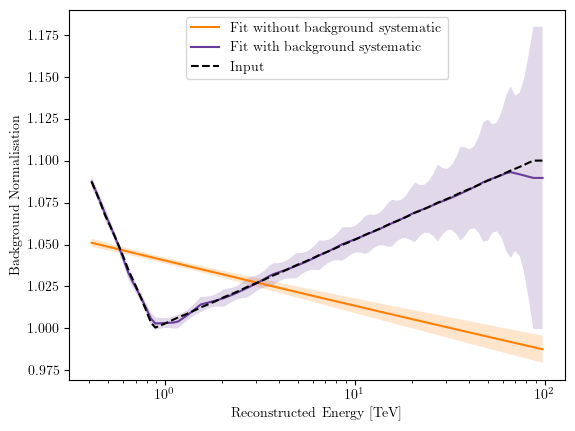

In [32]:

def plot_bkg(ax):
    dataset_asimov.models[1].spectral_model.plot((0.4, 100 ) *u.TeV, color = awo, label = labelwo, ax = ax)
    dataset_asimov.models[1].spectral_model.plot_error((0.4, 100 ) *u.TeV,ax = ax,
                                                      facecolor = awo)
    dataset_asimov_N.models[1].spectral_model.plot((0.4, 100 ) *u.TeV,ax = ax, color = aw, label = labelw)
    dataset_asimov_N.models[1].spectral_model.plot_error((0.4, 100 ) *u.TeV,ax = ax,
                                                        facecolor = aw,)
    setup.dataset_helper.models[1].spectral_model.plot((0.4, 100 ) *u.TeV,ax = ax, linestyle = 'dashed',
                                                      color = 'black', label = "Input")

    ax.legend(loc = 'lower left')
    ax.legend(loc = 'upper center')
    
    ax.set_yscale("linear")
    ax.set_xlabel("Reconstructed Energy [TeV]")
    ax.set_ylabel("Background Normalisation")
    
    return ax

fig, ax = plt.subplots(1,1)
plot_bkg(ax)

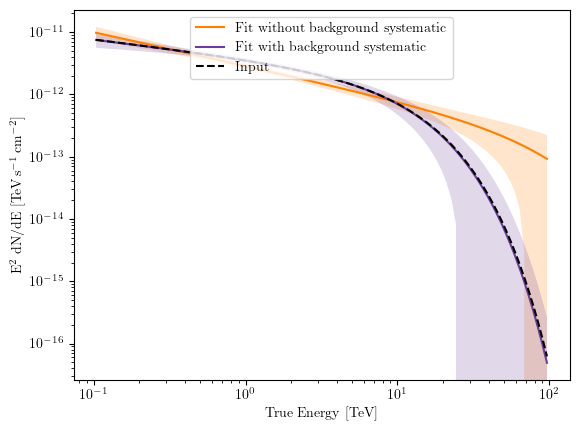

In [33]:

def plot_spec(ax):

    ep = 2
    dataset_asimov.models[0].spectral_model.plot((0.1, 100 ) *u.TeV, energy_power = ep, color = awo,  label = labelwo,ax = ax,)
    dataset_asimov.models[0].spectral_model.plot_error((0.1, 100 ) *u.TeV,ax = ax,
                                                      facecolor = awo, energy_power = ep)
    dataset_asimov_N.models[0].spectral_model.plot((0.1, 100 ) *u.TeV,ax = ax, energy_power = ep, color = aw,  label = labelw)
    dataset_asimov_N.models[0].spectral_model.plot_error((0.1, 100 ) *u.TeV,ax = ax,
                                                        facecolor = aw,
                                                        energy_power = ep)
    setup.dataset_helper.models[0].spectral_model.plot((0.1, 100 ) *u.TeV,ax = ax, energy_power = ep, color = 'black', linestyle = 'dashed',
                                                      label = "Input")
    
    ax.legend(loc = 'lower left')
    ax.legend(loc = 'upper center')
    
    ax.set_xlabel("True Energy [TeV]")
    
    
fig, ax = plt.subplots(1,1)
plot_spec(ax)

/home/katrin/Documents/gammapy/gammapy/datasets/map.py:1158: RuntimeWarning: invalid value encountered in divide
  yerr = excess_error / np.sqrt(npred_spec.data)


shift 1.0


/home/katrin/Documents/gammapy/gammapy/datasets/map.py:1158: RuntimeWarning: invalid value encountered in divide
  yerr = excess_error / np.sqrt(npred_spec.data)


shift 1.0


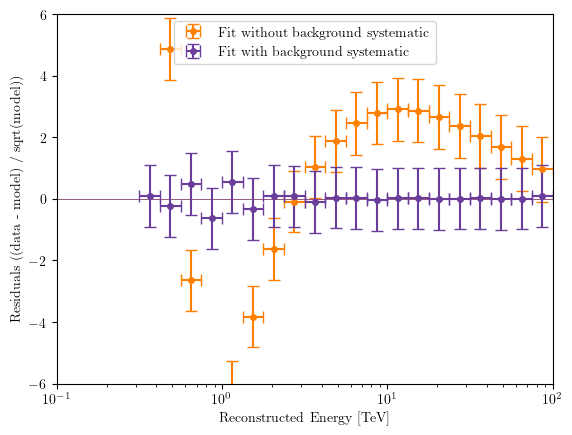

In [34]:
def plot_res(ax):

    dataset_asimov.plot_residuals_spectral(method = 'diff/sqrt(model)', color = awo,ax = ax, capsize = 4, label = labelwo)
    dataset_asimov_N.plot_residuals_spectral(method = 'diff/sqrt(model)', color = aw, ax = ax, capsize = 4, label = labelw)

    ax.set_xlabel("Reconstructed Energy [TeV]")
    ax.legend()
    ax.legend(loc = 'upper center')
    ax.set_ylim(-6,6)
    
fig, ax = plt.subplots(1,1)
plot_res(ax)



/home/katrin/Documents/gammapy/gammapy/datasets/map.py:1158: RuntimeWarning: invalid value encountered in divide
  yerr = excess_error / np.sqrt(npred_spec.data)


shift 1.0


/home/katrin/Documents/gammapy/gammapy/datasets/map.py:1158: RuntimeWarning: invalid value encountered in divide
  yerr = excess_error / np.sqrt(npred_spec.data)


shift 1.0


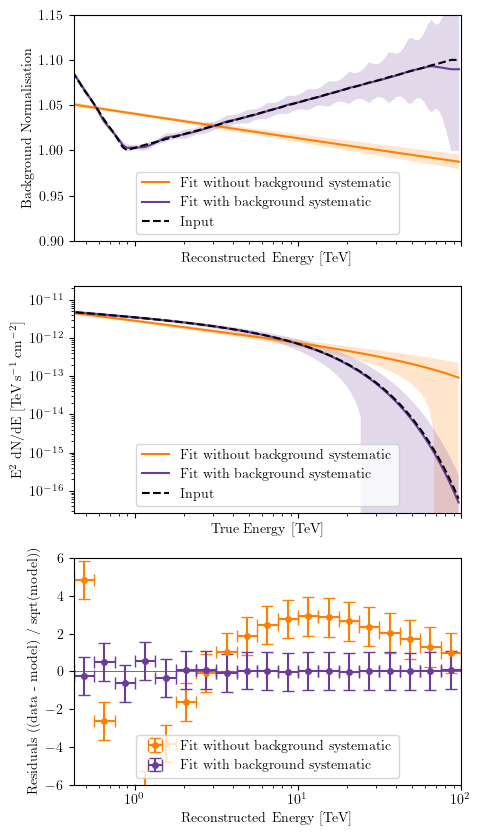

In [35]:
fig, ax = plt.subplots(3,1, figsize = (5,10), sharex = True)


plot_bkg(ax[0])
plot_spec(ax[1])
plot_res(ax[-1])

for a in ax:
    a.set_xlim(0.42, 100)
    a.legend(loc = 'lower center')
ax[0].set_ylim(0.9, 1.15)
ax[2].set_ylim(-6., 6)
    
fig.savefig(f'../{folder}/plots/bkg_{livetime}.pdf', bbox_inches = 'tight')


In [36]:
label = [ 'input', 'dataset_asimov', 'dataset_asimov_N']
for i, d in enumerate([ setup.dataset_helper, dataset_asimov, dataset_asimov_N]):
    print(label[i])

    for p in ['amplitude','index', 'lambda_','sigma']:
        par =d.models.parameters[p]
        factor = 1 
        if p == 'amplitude':
            factor = 1e12
        print(f" {p}: ${par.value*factor :.3}  \pm {par.error*factor :.3} $")
    print()

input
 amplitude: $3.85  \pm 0.0 $
 index: $2.3  \pm 0.0 $
 lambda_: $0.1  \pm 0.0 $
 sigma: $0.3  \pm 0.0 $

dataset_asimov
 amplitude: $2.86  \pm 0.27 $
 index: $2.54  \pm 0.103 $
 lambda_: $0.00997  \pm 0.0167 $
 sigma: $0.275  \pm 0.0178 $

dataset_asimov_N
 amplitude: $3.87  \pm 0.44 $
 index: $2.3  \pm 0.117 $
 lambda_: $0.103  \pm 0.0498 $
 sigma: $0.3  \pm 0.0191 $



In [37]:
models_no  = [dataset_asimov.models]
models  = [dataset_asimov_N.models]

In [38]:
headline = "\\textbf{Extended Source} &   $\Phi_0\ [10^{-12}\, \\text{cm}^{-2}\, \\text{s}^{-1}\,\\text{TeV}^{-1}]$  & $\Gamma$ & $\lambda = 1/E_c\ [\\text{TeV}^{-1}]$ & $\sigma\, [\\text{deg}]$   \\\  \hline "
input_ = '  Simulation input & $3.85 $  & $2.30 $  & $0.10 $ & 0.3  \\\  \hline'

par = models_no[0].parameters['amplitude']
without = rf' Without systematic & \errorsym {{{par.value*1e12:.3}}} {{{par.error*1e12:.3}}} '
par = models_no[0].parameters['index']
without += rf' & \errorsym {{{par.value:.3}}} {{{par.error:.3}}}   '
par = models_no[0].parameters['lambda_']
without += rf' & \errorsym  {{{par.value:.3}}} {{{par.error:.3}}}   '
par = models_no[0].parameters['sigma']
without += rf' & \errorsym  {{{par.value:.3}}} {{{par.error:.3}}}    \\  \hline'


par = models[0].parameters['amplitude']
with_ = rf' Fitting bkg. sys.   & \errorsym {{{par.value*1e12:.3}}} {{{par.error*1e12:.3}}}  '
par = models[0].parameters['index']
with_ += rf' & \errorsym  {{{par.value:.3}}} {{{par.error:.3}}}   '
par = models[0].parameters['lambda_']
with_ += rf' & \errorsym  {{{par.value:.3}}} {{{par.error:.3}}}'
par = models[0].parameters['sigma']
with_ += rf' & \errorsym  {{{par.value:.3}}} {{{par.error:.3}}}   \\  \hline'

print(headline)
print(input_)

print(without)
print(with_)

\textbf{Extended Source} &   $\Phi_0\ [10^{-12}\, \text{cm}^{-2}\, \text{s}^{-1}\,\text{TeV}^{-1}]$  & $\Gamma$ & $\lambda = 1/E_c\ [\text{TeV}^{-1}]$ & $\sigma\, [\text{deg}]$   \\  \hline 
  Simulation input & $3.85 $  & $2.30 $  & $0.10 $ & 0.3  \\  \hline
 Without systematic & \errorsym {2.86} {0.27}  & \errorsym {2.54} {0.103}    & \errorsym  {0.00997} {0.0167}    & \errorsym  {0.275} {0.0178}    \\  \hline
 Fitting bkg. sys.   & \errorsym {3.87} {0.44}   & \errorsym  {2.3} {0.117}    & \errorsym  {0.103} {0.0498} & \errorsym  {0.3} {0.0191}   \\  \hline


## Significance

In [39]:
retr

NameError: name 'retr' is not defined

In [39]:
%%time
dataset_asimov_ho = dataset_asimov.copy()
models = Models(dataset_asimov.models.copy())

models.parameters['amplitude'].value = 1e-24
models[0].parameters.freeze_all()
models.append(FoVBackgroundModel(dataset_name=dataset_asimov_ho.name))
models.parameters['tilt'].frozen = False
dataset_asimov_ho.models = models
fitting = 0
if fitting:
    fit_cor = Fit(store_trace=0)
    minuit_opts = {"tol": 0.1, "strategy": 2}
    fit_cor.backend = "minuit"
    fit_cor.optimize_opts = minuit_opts
    result_cor = fit_cor.run(dataset_asimov_ho)
    print(result_cor)
    print("saving")
    path = f'../{folder}/data/0_model_livetime_{livetime}_Ho.yml'
    dataset_asimov_ho.models.write(path,overwrite=True)
    
    
else:
    path = f'../{folder}/data/0_model_livetime_{livetime}_Ho.yml'
    dataset_asimov_ho.models = Models.read(path)

print()
print("Delta Ts: ", dataset_asimov_ho.stat_sum()- dataset_asimov.stat_sum())


FileNotFoundError: [Errno 2] No such file or directory: '../Bkgext_PKSflare_crab_cutoff/data/0_model_livetime_100.0_Ho.yml'

In [40]:
%%time
dataset_asimov_ho_N = dataset_asimov_N.copy()
models = Models(dataset_asimov_N.models.copy())

models.parameters['amplitude'].value = 1e-24
models[0].parameters.freeze_all()
dataset_asimov_ho_N.models = models
setup.set_piecewise_bkg_model(dataset_asimov_ho_N)
setup.set_bkg_prior(dataset_asimov_ho_N, magnitude= magnitude, corrlength= corrlength)
dataset_asimov_ho_N.models.parameters['_norm'].value = 1.
dataset_asimov_ho_N.models.parameters['norm0'].frozen = True
dataset_asimov_ho_N.models.parameters['norm1'].frozen = True
dataset_asimov_ho_N.models.parameters['norm2'].frozen = True
dataset_asimov_ho_N.models.parameters['norm3'].frozen = True

fitting = 0
if fitting:
    fit_cor = Fit(store_trace=0)
    minuit_opts = {"tol": 0.1, "strategy": 2}
    fit_cor.backend = "minuit"
    fit_cor.optimize_opts = minuit_opts
    result_cor = fit_cor.run(dataset_asimov_ho_N)
    print(result_cor)
    print("saving")
    path = f'../{folder}/data/0_model_livetime_{livetime}_Ho_N.yml'
    dataset_asimov_ho_N.models.write(path,overwrite=True)
    
    
else:
    path = f'../{folder}/data/0_model_livetime_{livetime}_Ho_N.yml'
    dataset_asimov_ho_N.models = Models.read(path)
    dataset_asimov_ho_N.models.parameters['_norm'].value = 1.

print()
print("Delta Ts: ", dataset_asimov_ho_N.stat_sum()- dataset_asimov_N.stat_sum())


FileNotFoundError: [Errno 2] No such file or directory: '../Bkgext_PKSflare_crab_cutoff/data/0_model_livetime_100.0_Ho_N.yml'

## Scan

In [ ]:
er

In [43]:
parameter_names_1  = ['amplitude', 'index', 'lambda_', 'sigma']

In [44]:
def computing_scan(dataset, note):
        
    fit_cor = Fit(store_trace=False)
    result_cor = fit_cor.run(dataset)
    print(dataset_asimov.models)
    
    results = []
    for parname1 in parameter_names_1 :
        if True: #parname1 == 'lambda_':
            print("scanning",  parname1)
            dataset.models.parameters[parname1].scan_n_values=numpoints
            result = fit_cor.stat_profile(dataset,
                                 dataset.models.parameters[parname1],
                                reoptimize = True
                                )

            contour_write = dict()
            for k in result.keys():
                print(k)
                if k != "fit_results":
                    contour_write[k] = [float(_) for _ in result[k]]#.tolist()
            print(contour_write)
            with open(f"../{c['folder']}/data/4_scan_{note}_{parname1}_{numpoints}_{livetime}.yml", "w") as outfile:
                yaml.dump(contour_write, outfile, default_flow_style=False)

            results.append(result)
    return results
        
def read_in_scan(note):
    results = []
    for parname1 in parameter_names_1 :
        try:
            with open(f"../{c['folder']}/data/4_scan_{note}_{parname1}_{numpoints}_{livetime}.yml", "r") as stream:
                contour = yaml.safe_load(stream)
        except:
            with open(f"../{c['folder']}/data/4_scan_{note}_{parname1}_{livetime}.yml", "r") as stream:
                contour = yaml.safe_load(stream)
        results.append(contour)
    return results


DatasetModels

Component 0: SkyModel

  Name                      : Crablog
  Datasets names            : None
  Spectral model type       : ExpCutoffPowerLawSpectralModel
  Spatial  model type       : GaussianSpatialModel
  Temporal model type       : 
  Parameters:
    index                      :      2.541  +/-    0.10             
    amplitude                  :   2.86e-12  +/- 2.7e-13 1 / (TeV s cm2)
    reference  (frozen)        :      1.000      TeV         
    lambda_                    :      0.010  +/-    0.02 1 / TeV     
    alpha      (frozen)        :      1.000                  
    lon_0      (frozen)        :    329.680      deg         
    lat_0      (frozen)        :    -30.222      deg         
    sigma                      :      0.275  +/-    0.02 deg         
    e          (frozen)        :      0.000                  
    phi        (frozen)        :      0.000      deg         

Component 1: FoVBackgroundModel

  Name                      : dataset-bkg
 

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.9/site-packages/astropy/units/quantity.py:666: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/katrin/Documents/gammapy/gammapy/modeling/models/spatial.py:651: RuntimeWarning: invalid value encountered in multiply
  return u.Quantity(norm * np.exp(exponent).value, "sr-1", copy=False)


Crablog.spectral.amplitude_scan
stat_scan
fit_results
{'Crablog.spectral.amplitude_scan': [2.3239042291280475e-12, 2.3710616497746898e-12, 2.4191760041426836e-12, 2.4682667106424194e-12, 2.518353581728979e-12, 2.569456831898256e-12, 2.621597085845244e-12, 2.6747953867879647e-12, 2.729073204960268e-12, 2.784452446276972e-12, 2.8409554611748363e-12, 2.898605053632984e-12, 2.9574244903762705e-12, 3.017437510265513e-12, 3.0786683338782132e-12, 3.1411416732837128e-12, 3.2048827420166916e-12, 3.2699172652531126e-12, 3.3362714901925443e-12, 3.403972196651279e-12], 'stat_scan': [846438.6727884904, 846437.9252807221, 846437.2450750348, 846436.6336745943, 846436.0928214127, 846435.6257571004, 846435.2335875788, 846434.9188245587, 846434.6838088777, 846434.5306068388, 846434.4609169376, 846434.4776118357, 846434.5831592844, 846434.7780707196, 846435.0648196004, 846435.4456239671, 846435.9212292874, 846436.4944781237, 846437.1664354247, 846437.936806121]}
scanning index
Crablog.spectral.index_scan

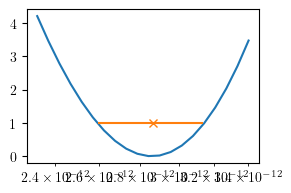

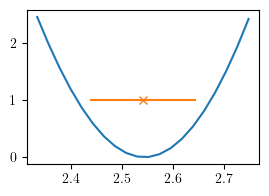

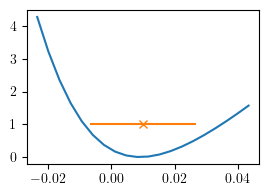

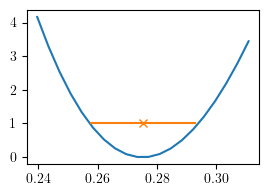

In [45]:
%%time
numpoints = 20
computing = 1
if computing:
    results = computing_scan(dataset_asimov, "2.15h")
else:
    results = read_in_scan("2.15h")
    path = f'../{folder}/data/0_model_livetime_{livetime}.yml'
    dataset_asimov.models = Models.read(path)
for i, r in enumerate(results):
    print(r)
    fig,ax = plt.subplots(1,1, figsize = (3,2))
    plt.plot(r[list(r.keys())[0]], r['stat_scan'] - np.min(r['stat_scan']))

    if i == 0 :
        ax.set_xscale('log')
    ax.errorbar(x = dataset_asimov.models.parameters[parameter_names_1[i]].value,
               y = 1,
               xerr = dataset_asimov.models.parameters[parameter_names_1[i]].error,
               fmt = 'x')

In [ ]:
%%time
computing = 0
numpoints = 20

if computing:
    dataset_asimov_N.models.parameters['lon_0'].frozen = True
    dataset_asimov_N.models.parameters['lat_0'].frozen = True
    
    results_N = computing_scan(dataset_asimov_N, "N_2.15h")
else:
    results_N = read_in_scan("N_2.15h")
    try:
        path = f'../{folder}/data/0_model_nui_livetime_{livetime}.yml'
        dataset_asimov_N = Dataset_load.load_dataset_N(dataset_asimov_N, path,bkg_sys = False)        
    except:
        path = f'../{folder}/data/0_model_nui_livetime_{livetime}_1000.yml'
        dataset_asimov_N = Dataset_load.load_dataset_N(dataset_asimov_N, path,bkg_sys = False)        
        
print(results_N)

In [ ]:
results_N  = results

In [ ]:
import upper_limit_18_02
import colors as s
colors_ = [s.blue, s.orange,
          s.lblue, s.lorange]

#colors_ = [awo[0] , aw[0],
#           awo[1] , aw[1]]

for i, p in enumerate(parameter_names_1):
    #if p == 'index':
    if True:
        stat_profile_N = results_N[i]
        stat_profile = results[i]

        stat_profile_N['stat_scan'] -= np.min(stat_profile_N['stat_scan'])
        stat_profile['stat_scan'] -= np.min(stat_profile['stat_scan'])

        fig = plt.figure()
        ll_N_a = stat_profile_N.copy()
        case = 'spectral'
        if p == 'sigma':
            case = 'spatial'
            
        amplitude_err = dataset_asimov.models[0].parameters[p].error
        amplitude = dataset_asimov.models[0].parameters[p].value
        amplitude_err_N = dataset_asimov_N.models[0].parameters[p].error
        amplitude_N = dataset_asimov_N.models[0].parameters[p].value

        fig, ax = plt.subplots(1,1)
            
        ### LIKELIHOOD
        # scan
        ll_a = stat_profile.copy()
        ul_a = upper_limit_18_02.upper_limit(ll_a,0,0,  name=f'{dataset_asimov.models[0].name}.{case}.{p}_scan')
        L_a, x_a = ul_a.interpolate()
        plt.plot(x_a, L_a(x_a),label = "-2log (L)", linestyle = 'dashed', color = colors_[0])
    
        ylim= ax.get_ylim()
        ymax = 2#ylim[1]
        min_, er_neg, er_pos = ul_a.likelihood_error_asymmetric()
        min_ = min_[0]; er_neg = er_neg[0]; er_pos = er_pos[0]; 
        dataset_asimov.models.parameters[p].error_n = er_neg
        dataset_asimov.models.parameters[p].error_p = er_pos
        
        factor = 1
        if p == 'amplitude':
            factor = 1e11

        ax.fill_between(  [min_-er_neg, min_+ er_pos], ylim[0], ymax, alpha = 0.5, color=colors_[2],
                        label = f'1$\sigma$ error (Scan): -{er_neg*factor:.2} +{er_pos*factor:.2} ')
     
        
        ax.vlines(amplitude-amplitude_err, ylim[0], ymax, color = colors_[0], linestyle ='dotted')
        ax.vlines(amplitude+amplitude_err, ylim[0], ymax, color = colors_[0], linestyle ='dotted',
                 label =  f'1$\sigma$ error (Minuit): {amplitude_err*factor:.2}')

           
        ### POSTERIOR
        # scan
        ul_N_a = upper_limit_18_02.upper_limit(ll_N_a,0,0, 
                                               name=f'{dataset_asimov.models[0].name}.{case}.{p}_scan')
        L_N_a, x_N_a = ul_N_a.interpolate()
        plt.plot(x_N_a, L_N_a(x_N_a),label = "-2log (P)", color = colors_[1])
        
        
        min_N, er_negN, er_posN = ul_N_a.likelihood_error_asymmetric()
        min_N = min_N[0]; er_negN = er_negN[0]; er_posN = er_posN[0]; 
        dataset_asimov_N.models.parameters[p].error_n = er_negN
        dataset_asimov_N.models.parameters[p].error_p = er_posN


        ax.fill_between(  [min_N-er_negN, min_N+ er_posN], ylim[0], ymax, alpha = 0.5, color = colors_[3],
                        label = f'1$\sigma$ error (Scan): -{er_negN*factor:.5} +{er_posN*factor:.5} ')
        ax.vlines(amplitude_N-amplitude_err_N, ylim[0], ymax,color = colors_[1] ,
                  linestyles='dotted'
                 )
        ax.vlines(amplitude_N+amplitude_err_N, ylim[0], ymax,color = colors_[1],
                  linestyles='dotted',
                    label = f'1$\sigma$ error (Minuit): $\pm${amplitude_err_N*factor:.5}')
                 
        nn = 2
        #ax.set_xlim(amplitude_N-amplitude_err_N*nn, 
        #           amplitude_N+amplitude_err_N*nn)
        ax.set_ylim(np.min(stat_profile['stat_scan'])-0.5,
                    np.min(stat_profile['stat_scan'])+ 3)

        
        
       
    
    
        xx = ax.get_xlim()
        alpha = 0.6
        ax.hlines(0, xx[0], xx[1], color = 'grey', alpha = alpha)
        ax.hlines(1, xx[0], xx[1], color = 'grey', alpha = alpha)
        if p == 'amplitude':
            str_= "[$\\mathrm{TeV^{-1}\\,s^{-1}\\,cm^{-2}}$]"
            plt.xlabel(f"Source strength " + str_) 
        else:
            plt.xlabel(p)
        plt.ylabel("-2log (L) [arb. unit]")
        plt.legend(ncol = 2)

    fig.savefig(f"../{c['folder']}/plots/4_scan_{p}.pdf")
    
    

In [ ]:
headline = "\\textbf{Extended Source} & &  $\Phi_0\ [10^{-11}\, \\text{cm}^{-2}\, \\text{s}^{-1}\,\\text{TeV}^{-1}]$  & $\Gamma$ & $\lambda = 1/E_c\ [\\text{TeV}^{-1}]$ & $\sigma\, [\text{deg}]$ &  \\\  \hline "
input_ = ' & Simulation input & $3.85 $  & $2.30 $  & $0.10 $ & 0.3  \\\  \hline'

par = models_no[0].parameters['amplitude']
without = rf' &Without systematic & \error {{{par.value*1e11:.3}}} {{{par.error*1e11:.3}}}  {{{par.error_p*1e11:.3}}}  {{{par.error_n*1e11:.3}}} '
par = models_no[0].parameters['index']
without += rf' & \error {{{par.value:.3}}} {{{par.error:.3}}}  {{{par.error_p:.3}}}  {{{par.error_n:.3}}} '
par = models_no[0].parameters['lambda_']
without += rf' & \error  {{{par.value:.3}}} {{{par.error:.3}}}  {{{par.error_p:.3}}}  {{{par.error_n:.3}}}  \\  \hline'
par = models_no[0].parameters['sigma']
without += rf' & \error  {{{par.value:.3}}} {{{par.error:.3}}}  {{{par.error_p:.3}}}  {{{par.error_n:.3}}}  \\  \hline'


par = models[0].parameters['amplitude']
eff = rf' Effective Area & With fitting  & \error {{{par.value*1e11:.3}}} {{{par.error*1e11:.3}}}  {{{par.error_p*1e11:.3}}}  {{{par.error_n*1e11:.3}}} '
par = models[0].parameters['index']
eff += rf' & \error  {{{par.value:.3}}} {{{par.error:.3}}}  {{{par.error_p:.3}}}  {{{par.error_n:.3}}} '
par = models[0].parameters['lambda_']
eff += rf' & \error  {{{par.value:.3}}} {{{par.error:.3}}}  {{{par.error_p:.3}}}  {{{par.error_n:.3}}}  \\  \hline'
par = models[0].parameters['sigma']
eff += rf' & \error  {{{par.value:.3}}} {{{par.error:.3}}}  {{{par.error_p:.3}}}  {{{par.error_n:.3}}}  \\  \hline'


